In [73]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

# Autocorrelate Function

In [44]:
def autocorrelate(syg, tau=0):
    N = len(syg)

    syg_2 = np.zeros(3*N-2, dtype = 'float')
    syg_2[N-1:2*N-1] = np.copy(syg)

    syg_1 = np.zeros(3*N-2, dtype= 'float')
    syg_1[N+tau:tau+2*N] = syg
    
    return np.dot(syg_1, syg_2)

def auto_corr_for_tau(syg, low=-10, high=10, normed=True):
    tau = np.arange(low, high)

    f_corr = np.zeros(len(tau))
    norm = autocorrelate(syg)

    for index, t in enumerate(tau):
        f_corr[index] = autocorrelate(syg, t)

    if normed:
        f_corr /= norm

    return tau, f_corr

In [4]:
t = np.arange(0, 2, 1/32)
x = np.sin(2 * np.pi * 1 * t)

31.385128972903377


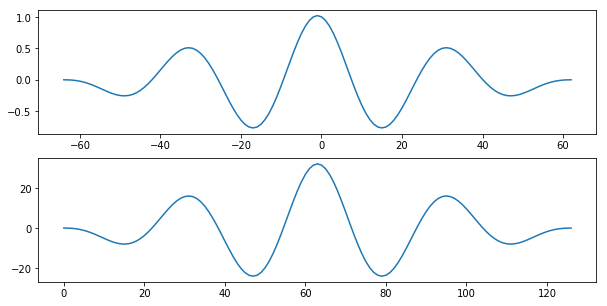

31.385128972903377


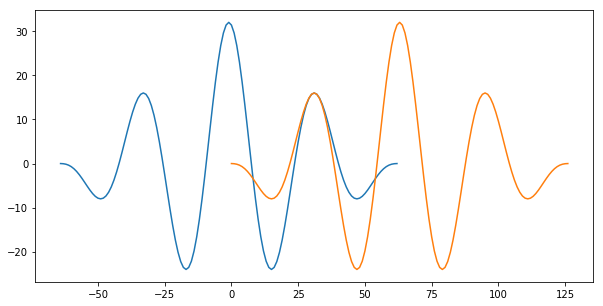

In [5]:
plt.figure(figsize=((10,5)))

plt.subplot(2,1,1)
plt.plot(*auto_corr_for_tau(x, -len(x), len(x)-1))

plt.subplot(2,1,2)
plt.plot(np.correlate(x, x, 'full'))
plt.show()

plt.figure(figsize=((10,5)))
plt.plot(*auto_corr_for_tau(x, -len(x), len(x)-1, normed=False))
plt.plot(np.correlate(x, x, 'full'))
plt.show()

# Read Signal

In [6]:
from obci_readmanager.signal_processing.read_manager import ReadManager
from pprint import pprint
def read_signals(filename):
    TMSI_OFFSET = 0.0715

    # Initialize the ReadManager
    mgr = ReadManager(filename + ".xml", filename + ".raw", filename + ".tag")
    
    o1 = mgr.get_channels_samples(['O1']) * TMSI_OFFSET
    return o1

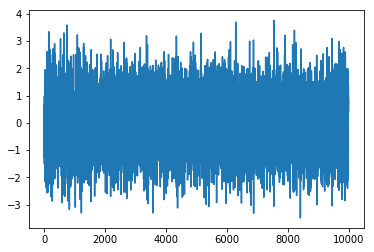

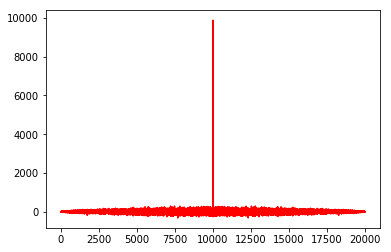

In [63]:
np.random.seed(10000)
x = np.random.normal(size=10000).astype('float')
plt.plot(x)
plt.show()

plt.plot(auto_corr_for_tau(x, -len(x), len(x)-1, normed=False)[1], color='red')
# plt.plot(np.correlate(x, x, 'full'))
plt.show()

In [126]:
o1 = read_signals('../../../data/cw1_otwarte')

2018-10-11 13:58:20,036 - tags_file_reader - ERROR - Couldn`t open tags file.
2018-10-11 13:58:20,037 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [129]:
o2 = read_signals('../../../data/cw1_zamkniete')

2018-10-11 14:00:44,897 - tags_file_reader - ERROR - Couldn`t open tags file.
2018-10-11 14:00:44,898 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [151]:
def filter_signal(signal):
    b_highpass, a_highpass = ss.butter(1, 0.1 / 1024/2, 'highpass')
    b_lowpass, a_lowpass = ss.butter(4, 40 / 1024/2, 'low')
    b_notch, a_notch = ss.iirnotch(50 / 1024/2, 30)
    filt = np.copy(signal)
    filt = ss.filtfilt(b_notch, a_notch, filt)
    filt = ss.filtfilt(b_highpass, a_highpass, filt)
    filt = ss.filtfilt(b_lowpass, a_lowpass, filt)
    return filt

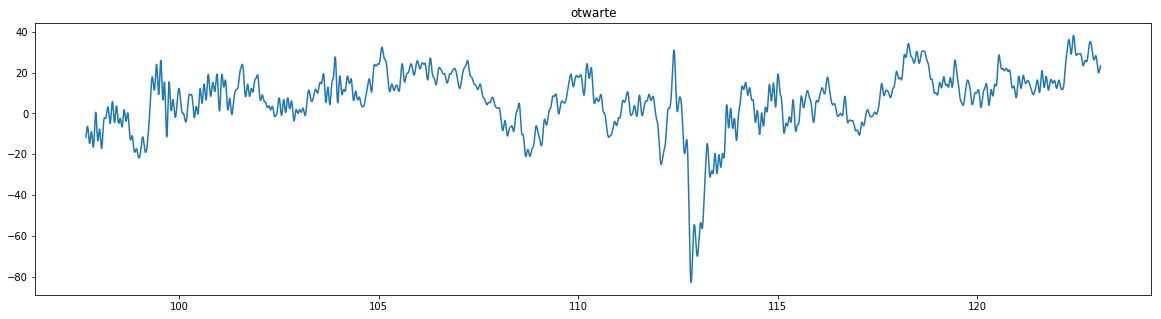

In [152]:
t = np.arange(0, len(o1)) / 1024
filt_o1 = filter_signal(o1)[100000:-500000]

plt.figure(figsize=(20, 5))
plt.plot(t[100000:-500000], filt_o1)
plt.title('otwarte')
plt.show()

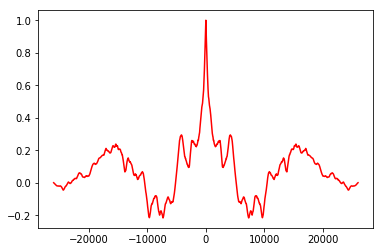

In [183]:
plt.plot(*auto_corr_for_tau(filt_o1, -len(filt_o1), len(filt_o1)-1, normed=True), color='red')
plt.show()

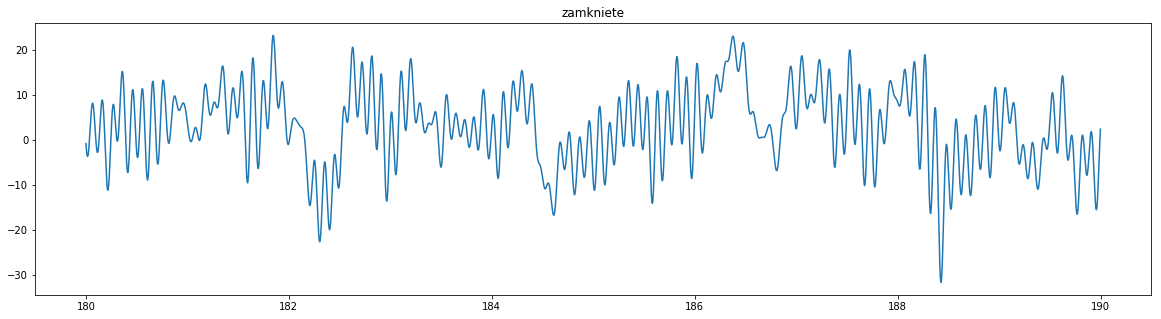

In [171]:
t = np.arange(0, len(o2)) / 1024

start = 3 * 60 * 1024

filt_o2 = filter_signal(o2)[start:start + 1024*10]

plt.figure(figsize=(20, 5))
plt.plot(t[start:start + 1024*10], filt_o2)
plt.title('zamkniete')
plt.show()

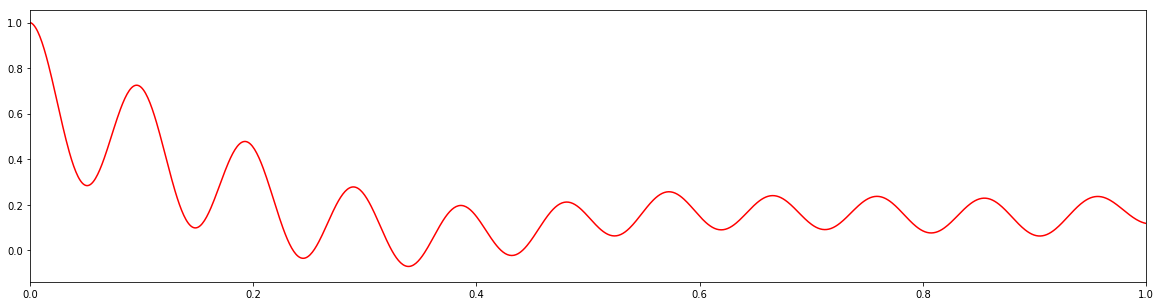

In [184]:
plt.figure(figsize=(20,5))
t, corr = auto_corr_for_tau(filt_o2, -len(filt_o2), len(filt_o2)-1, normed=True)
plt.plot(t/1024, corr, color='red')
plt.xlim(0,1)
plt.show()

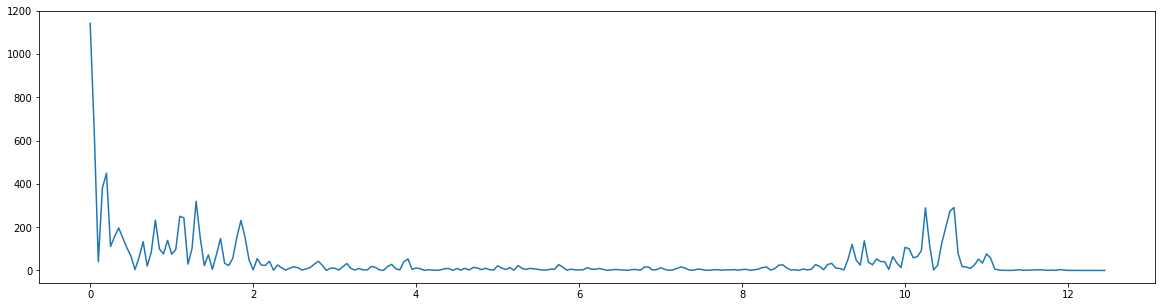

In [188]:
plt.figure(figsize=(20,5))
plt.plot(np.fft.rfftfreq(len(corr), 1/1024)[:250], abs(np.fft.rfft(corr)[:250]))
plt.show()

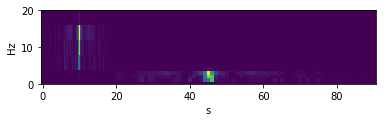

In [182]:
f, t, s = ss.spectrogram(corr, 1024)
plt.pcolormesh(t, f, s)
plt.imshow(s)
plt.ylabel('Hz')
plt.xlabel('s')
plt.ylim(0,20)
plt.show()